## Import lib

In [1]:
from DataSet import DataSet
from SimGPBO_old import SimGPBO_old
from SimGPBO import SimGPBO
from PostProcessor import PostProcessor
import GPy
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def plot_map(ds: DataSet, vector: np.array, title: str=None) -> None:
    map = np.full((
                        np.max(ds.set['ch2xy'][:,0]),
                        np.max(ds.set['ch2xy'][:,1])
                        ), 
                        np.nan)
    for i in range(ds.set['ch2xy'].shape[0]):
        map[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = vector[i]
    plt.figure()
    plt.imshow(map, cmap='viridis', vmin=np.nanmin(map), vmax=np.nanmax(map))
    plt.colorbar(label="values")
    plt.title(title)
    plt.show()


## Import data

In [14]:
ds = DataSet('../data/','nhp','Cebus1_M1_190221.mat','cebus1')
ds.load_matlab_data() # load data from the dataset_file

## Simulation 

In [19]:
sim = SimGPBO(name = 'tttest_hyp_valid', 
                    ds = ds,
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 40,
                    KAPPA = 6,
                    NB_RND = 1
                    )

In [20]:
sim.select_emgs([0])

In [21]:
sim.run_simulations(gp_origin='gpytorch', response_type='valid', 
                         hyperparams_storage=True, )

Global Progress: 100%|██████████| 1/1 [00:18<00:00, 18.97s/iter]

Elapsed time: 18.96584916114807 seconds
final save of tttest_hyp_valid in:   results/gpbo_gpytorch_UCB_cebus1_tttest_hyp_valid.npz


In [35]:
mean = sim.gp.mean.detach().numpy()
std = sim.gp.std.detach().numpy()
best_f = np.max(sim.gp.mean[sim.best_pred_x_measured[0, 0, 0, 39].item()].numpy())

In [36]:
print(np.max(mean))
print(best_f)

2.7261402127684677
2.7261402127684677


In [37]:
print(mean)

[-0.38837915 -0.68403103 -0.51184819 -0.58014306 -0.4687153  -0.40788496
 -0.56435919 -0.80146463  0.4012098  -0.04095192  0.09293886  0.80378928
  0.17850752 -0.33370969 -0.43341766 -0.47324781 -0.54112072 -0.54287155
 -0.12990896 -0.4392505   0.09742356  2.61696417  0.93235188  0.26927804
 -0.04596852 -0.23646654 -0.39221889 -0.46411461 -0.0163034   0.1901895
  0.72748913  0.93427454  2.14357213  2.72614021  2.37202132  0.6118583
 -0.36719442 -0.74003834 -0.59341409 -0.13939458  0.25120124 -0.01080793
 -0.09212537  0.27182926  0.60601901  0.3690404  -0.37254792 -0.80326517
 -0.62256084 -0.40400816 -0.29993201 -0.43575083 -0.51697067 -0.47441639
 -0.40102391 -0.45257094 -0.7131103  -0.62086739 -0.34391209 -0.30394068
 -0.50369293 -0.78401776 -0.63243577 -0.63449542 -0.81164297 -0.6412409
 -0.56394072 -0.52102078 -0.43789229 -0.44373049 -0.45649768 -0.50228229
 -0.52365601 -0.57320027 -0.56026285 -0.50022705 -0.60190011 -0.78236399
 -0.79809354 -0.81406772 -0.61383851 -0.49058611 -0.59

In [56]:
np.mean(mean)

-0.5513830889424853

In [9]:
map_emg = np.full((ds.set['sorted_respMean'].shape[1],
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_emg[:,int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = ds.set['sorted_respMean'][i,:]
# print(map_emg)

map_mean = np.full((
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,0])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map_mean[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = mean[i]
# print(map_mean)

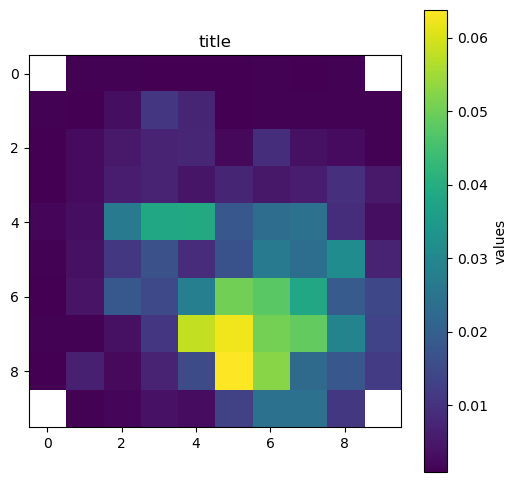

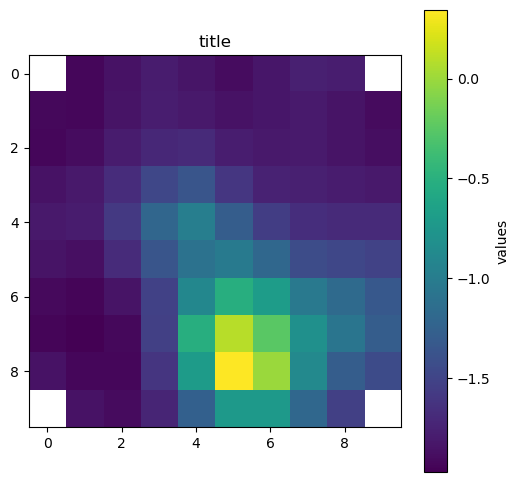

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(map_emg[3], cmap='viridis', vmin=np.nanmin(map_emg[3]), vmax=np.nanmax(map_emg[3]))
plt.colorbar(label="values")
plt.title("title")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(map_mean, cmap='viridis', vmin=np.nanmin(map_mean), vmax=np.nanmax(map_mean))
plt.colorbar(label="values")
plt.title("title")
plt.show()

In [31]:
print(sim.P_test_x_idx)
print(sim.P_test_y)

tensor([[[[61,  7, 88, 78, 89, 79, 88, 94, 87, 18,  1, 30, 47,  8, 77, 48, 37,
           38, 14, 24, 28, 32, 43, 21, 22, 31, 11, 20, 42, 33, 34, 45, 64, 35,
           83,  3, 40, 17, 56, 59]]]])
tensor([[[[0.0024, 0.0022, 0.0029, 0.0022, 0.0024, 0.0021, 0.0025, 0.0064,
           0.0033, 0.0091, 0.0034, 0.0179, 0.0022, 0.0145, 0.0024, 0.0040,
           0.0028, 0.0043, 0.0060, 0.0099, 0.0102, 0.0324, 0.0132, 0.0372,
           0.0199, 0.0199, 0.0186, 0.0114, 0.0094, 0.0383, 0.0347, 0.0142,
           0.0021, 0.0167, 0.0022, 0.0044, 0.0130, 0.0048, 0.0031, 0.0073]]]],
       dtype=torch.float64)


In [46]:
from scipy.stats import norm

In [90]:
A = 10

z = (mean - best_f - A) / (std + 1e-9)
ei = (mean - best_f - A) * norm.cdf(z) + std * norm.pdf(z)

next_query_idx = np.argmax(ei)
print(next_query_idx)


21
